link artigo : https://openaccess.thecvf.com/content_cvpr_2018/papers/Sun_Pix3D_Dataset_and_CVPR_2018_paper.pdf

link git : https://github.com/xingyuansun/pix3d

In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 'sofa', 'chair', 'desk', 'bed', 'bookcase', 'tool', 'misc', 'wardrobe', 'table'
category = "desk"

with open("data/category.txt", "w") as file:
    file.write(category)

from data.dataloader_filtered import train_loader, test_loader, val_loader

Loading 700 files of category desk.


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [4]:
from model.model import Rec3D
model = Rec3D().to(device)

In [5]:
try:
    model.load_state_dict(torch.load("model/weights/weights_{}.pdf".format(category)))
    print("Weights loaded")
except:
    pass

model

Rec3D(
  (vgg_pretrained): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

In [6]:
EPOCHS = 50
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn_1 = nn.MSELoss()
loss_fn_2 = nn.MSELoss()

In [7]:
train_losses = [list(), list()]
valid_losses = [list(), list()]

In [8]:
def train_step(model, loader, loss_fn_1, loss_fn_2, optimizer, device) -> float:
  train_loss = [0, 0]
  for X, Y_mask, Y_cloud, image in loader:
    if X.shape == (1,1):
      continue
    model.zero_grad()
    y_pred = model(X.to(device), torch.rand((1,128,128,128)).to(device))
    loss_1 = loss_fn_1(y_pred[0], Y_mask.to(device))
    loss_2 = loss_fn_2(y_pred[1], Y_cloud.to(device))
    loss_1.backward(retain_graph=True)
    loss_2.backward()
    optimizer.step()
    train_loss[0] +=  loss_1.item()
    train_loss[1] +=  loss_2.item()
  train_loss[0] = train_loss[0] / len(loader)
  train_loss[1] = train_loss[1] / len(loader)
  return train_loss


def validation_step(model, loader, loss_fn_1, loss_fn_2, device) -> float:
  loss = [0, 0]
  with torch.no_grad():
    for X, Y_mask, Y_cloud, image in loader:
      if X.shape == (1,1):
        continue
      y_pred = model(X.to(device), torch.rand((1,128,128,128)).to(device))
      loss_1 = loss_fn_1(y_pred[0], Y_mask.to(device)).item() 
      loss_2 = loss_fn_2(y_pred[1], Y_cloud.to(device)).item()
      loss[0] += loss_1
      loss[1] += loss_2
  loss[0] = loss[0] / len(loader)
  loss[1] = loss[1] / len(loader)
  return loss

In [9]:
from tqdm import tqdm
from copy import deepcopy

def train_model():
  for epoch in tqdm(range(EPOCHS)):
    train_loss = train_step(model, train_loader, loss_fn_1, loss_fn_2, optimizer, device)
    train_losses[0].append(train_loss[0])
    train_losses[1].append(train_loss[1])
    valid_loss = validation_step(model, val_loader, loss_fn_1, loss_fn_2, device)
    valid_losses[0].append(valid_loss[0])
    valid_losses[1].append(valid_loss[1])
    if valid_losses[-1] == min(valid_losses):
      best_model = deepcopy(model)
  return best_model

In [10]:
model.freeze_encoder_block()
best_model = train_model()

100%|██████████| 50/50 [1:19:36<00:00, 95.53s/it]


In [11]:
model.unfreeze_encoder_block()
best_model = train_model()

  6%|▌         | 3/50 [04:55<1:17:05, 98.42s/it]

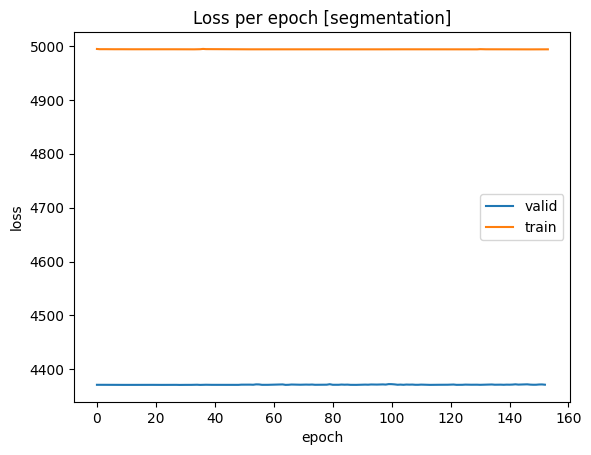

In [ ]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid[0], label='valid')
  plt.plot(loss_train[0], label='train')
  plt.title('Loss per epoch [segmentation]')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

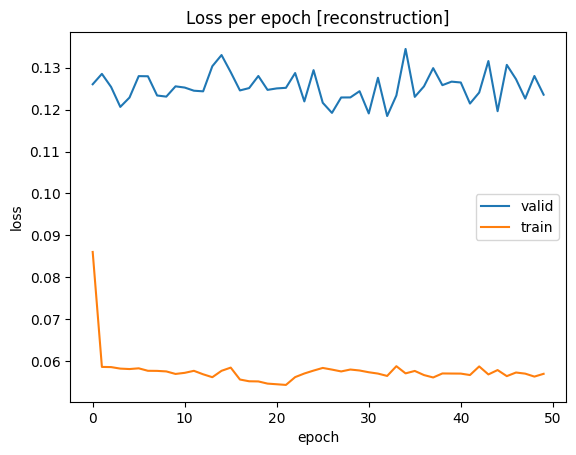

In [ ]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid[1], label='valid')
  plt.plot(loss_train[1], label='train')
  plt.title('Loss per epoch [reconstruction]')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

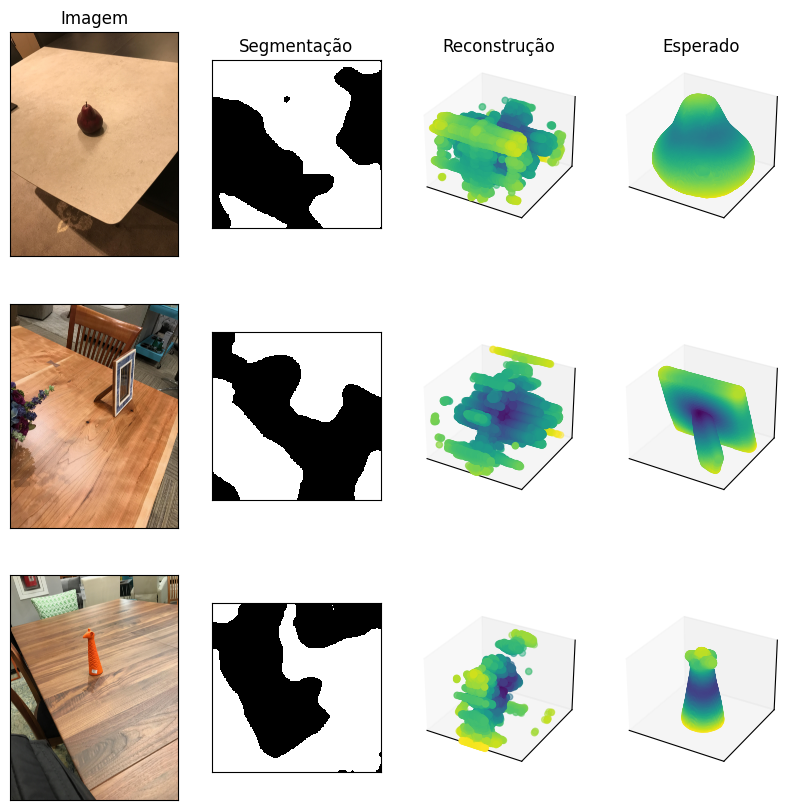

In [ ]:
threshold_seg = 0.7
threshold_rec = 0.15

fig = plt.figure(figsize=(10, 10))

with torch.no_grad():
    j = 0
    for X, y_mask, y_cloud, image in test_loader:
        if X.shape == (1,1):
            continue

        y = model(X.to(device), torch.zeros((1,128,128,128)).to(device))

        ax = fig.add_subplot(3, 4, 1+4*j)
        ax.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.title.set_text("Imagem")
        
        ax = fig.add_subplot(3, 4, 2+4*j)
        ax.imshow((y[0].squeeze() > threshold_seg).cpu().numpy().astype(np.uint8), cmap="gray", interpolation="None")
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.title.set_text("Segmentação")

        t = (y[1].flatten() >= threshold_rec).nonzero(as_tuple=True)[0]
        t = torch.stack((t // (128*128), (t % (128*128))//128, t % 128), dim=1)
        cloud = t.cpu().numpy()

        ax = fig.add_subplot(3, 4, 3+4*j, projection='3d')
        ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=((cloud[:, 0] - 64)**2 + (cloud[:, 1] - 64)**2 + (cloud[:, 2] - 64)**2)**0.5, cmap="viridis")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlim(-1, 129)
        ax.set_ylim(-1, 129)
        ax.set_zlim(-1, 129)
        if j == 0:
            ax.title.set_text("Reconstrução")

        t = y_cloud.flatten().nonzero(as_tuple=True)[0]
        t = torch.stack((t // (128*128), (t % (128*128))//128, t % 128), dim=1)
        cloud = t.cpu().numpy()

        ax = fig.add_subplot(3, 4, 4+4*j, projection='3d')
        ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=((cloud[:, 0] - 64)**2 + (cloud[:, 1] - 64)**2 + (cloud[:, 2] - 64)**2)**0.5, cmap="viridis")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlim(-1, 129)
        ax.set_ylim(-1, 129)
        ax.set_zlim(-1, 129)
        if j == 0:
            ax.title.set_text("Esperado")
        
        j += 1
        if j == 3:
            break

In [ ]:
torch.save(best_model.state_dict(), "model/weights/weights_{}.pdf".format(category))